<a href="https://colab.research.google.com/github/Darlywa/demo-repo/blob/main/cetm47_workshop4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import required libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from nltk.corpus import brown

In [ ]:
#Download 
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def read_data(path):
  """The function reads in data, separate the labels and the input message and convert the labels to numeric values
  Parameters
  ==========
  Input: str data path

  Return
  ======
  Output: labels: pd.Series, input_message: pd.Series
  """
  data = pd.read_csv(path)

  #separate the input_message and the labels
  labels = data["Category"]

  #Convert the labels to numeric values
  key_dict = {"spam": 0, "ham": 1}
  labels = labels.replace(key_dict)

  #Extract the input message
  input_message = data["Message"]

  return labels, input_message


In [ ]:
def data_cleaning_func(x_data):
  """The function prunes an input data of stop words, and all punctuations.

  Library required:
  ================
  import nltk
  nltk.download("stopwords")
  from nltk.corpus import stopwords

  Parameter:
  =========
  Input: pd.Series.

  Returns:
  =======
  Output: list.
  """
  #Extract the stopwords
  stop_words = set(stopwords.words("english"))

  #Convert the word charaters to low characters
  x_data = [item.lower() for item in x_data.to_list()]

  cleaned_message = []
  for sentence in x_data:
    filtered_sentence = ""
    for w in sentence:

      #Check if the word is in stop_words
      if w not in stop_words:

        #if is false, remove all punctuations from that word
        punc_removed_sentence = re.sub(r'[^\w\s]', '', w)

        #Add the filtered word to the empty string
        filtered_sentence = filtered_sentence + punc_removed_sentence
      
    #Append the filtered sentence to the cleaned message
    cleaned_message.append(filtered_sentence)
  return cleaned_message

In [ ]:
def vet_split_func(cleaned_message, labels, max_feature=0, use_max_features=False, test_size=0.3, shuffle = False):
  """The function accepts clean data, vectoriizer the data and split it using train_test_split function.

  Parameters
  ==========
  Input: cleaned_message:list, labels:np.ndarrays, test_size:float - default value (0.3), 
  shuffle: Boolean - default (False), max_feature: int

  Return
  ======
  Output: X_train:np.ndarrays, X_test:np.ndarrays, y_train:np.ndarrays, y_test:np.ndarrays

  """
  #Instantiate the object
  if use_max_features:
    count_vector = CountVectorizer(max_features=max_feature)
  else:
    count_vector = CountVectorizer()

  #Fit and transform the cleaned_input_data.
  X = count_vector.fit_transform(cleaned_message).toarray()

  #Convert the labels to ndarrays
  y = np.array(labels)

  #Split the data
  if shuffle:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = shuffle, random_state = 42)
  else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = shuffle)
  
  return X_train, X_test, y_train, y_test

In [38]:
def model_performance(model_dict):
  """The function trains the model, makes predictions and evaluate the accuracy score

  Parameter
  =========
  Input: dict

  Return
  ======
  Output: dict containing the model initial and its accuracy score.
  """
  accuracy_score = {}
  trained_model_dict = {}
  for model_name, model_instantiation in model_dict.items():
    model = model_instantiation

    #fit the model
    trained_model = model.fit(X_train, y_train)
    trained_model_dict[model_name] = trained_model

    #Make prediction
    y_pred = trained_model.predict(X_test)

    #Evaluate the model
    accuracy_score[model_name] = round(metrics.accuracy_score(y_test, y_pred), 3)

  return accuracy_score, trained_model_dict

In [80]:
def kfold_model_performance(model_dict, input_data, labels, test_size=0.001, k=5, shuffle=False):
  """Function that evaluates models performance using kfold cross validation
  
  Parameters
  ==========
  Input: model_dict: dictionary, input_data: pd.Series, labels: pd.Series, test_size: float = 0.001, 
  k: int =5, shuffle: boolean = False, split_shuffle: boolean = False

  Return
  ======
  Output: Accuracy score: dict
  """
  #split the data set without shuffle. NB: I am not keeping any test data, rather all the data will be splited by kFold
  X_train, X_test, y_train, y_test = vet_split_func(cleaned_message=input_data, labels=labels, test_size = test_size, shuffle=shuffle)

  #Instantiate the KFold. The default state of shuffle is False
  kf = KFold(n_splits = k)

  dict_score = {}
  for model_name, model_instantiation in model_dict.items():
    result = []

    #Obtain the train indices and the test indices
    for train_index, test_index in kf.split(X_train, y_train):
      X_train_fold = X_train[train_index]
      y_train_fold = y_train[train_index]
      X_test_fold = X_train[test_index]
      y_test_fold = y_train[test_index]

      #Instantiate the model
      model_object = model_instantiation

      #fit the model
      model_object.fit(X_train_fold, y_train_fold)

      #predict
      y_pred_fold = model_object.predict(X_test_fold)

      #Evaluate the score
      score = (sum(y_test_fold == y_pred_fold)/len(y_pred_fold))

      #Attach the score to the dictionary
      result.append(round(score, 3))

    #Attach the result to dict
    dict_score[model_name] = result
    result = []
  return dict_score

In [97]:
def average_kfold_result(collated_result):
  """The function average the kfold result per model per split value
  Parameter
  =========
  Input: The general result obtained from multiple k-iteration

  Return
  ======
  Output: A list of dictionary showing the average performance for k in each model
  """
  result = []
  for d in collated_result:
    mean_dict = {}
    for i in d.keys():
      mean_dict[i] = round(sum(d[i])/len(d[i]), 3)
    result.append(mean_dict)
  return result

In [ ]:
print("Solutions to Workshop 4 Exercises - Author: Ifeanyi Emeagi")
print("===========================================================")

Solutions to Workshop 4 Exercises - Author: Ifeanyi Emeagi


In [ ]:
#Mount my google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
print("Exercise 1-4: Read the csv file, convert the labels to numeric values, lower the input characters, remove stop words and all punctuations. \n")

#Reads in the data, separate the labels and the input message and convert the labels to numbers
data_path = "/content/drive/My Drive/Colab Notebooks/SMSData.csv"
labels, input_message = read_data(data_path)

#Clean the input_message
cleaned_message = data_cleaning_func(input_message)

#print 3 lines in the cleaned message
print("Sample of cleaned message: ", cleaned_message[:3])
print()
print("Sample of labels: ", labels.to_list()[:3])
print("From the labels values, this is a binary classification problem.")


Exercise 1-4: Read the csv file, convert the labels to numeric values, lower the input characters, remove stop words and all punctuatios. 

Sample of cleaned message:  ['g unl jurng pn crz vlble nl n bug n gre wrl l e buffe cne here g re w', 'k lr jkng wf u n', 'free enr n 2  wkl cp  wn f cup fnl k 21  2005 ex f  87121  receve enr quen x rec ppl 08452810075ver18']

Sample of labels:  [1, 1, 0]
From the labels values, this is a binary classification problem.


In [39]:
print("Exercise 5-10: Convert the input message to bag of words rep., split the data set, (no shuffle), \n train NB model and make prediction use same model to predict the y_train and share your observation \n")

#Convert the input_message into bow rep and split the data (no shuffle):
X_train, X_test, y_train, y_test = vet_split_func(cleaned_message, labels)

#Train the NB model, make prediction and evaluate the score
model_dict = {"NB": GaussianNB()}
accuracy_score, model = model_performance(model_dict)

print(f"The model accuracy score: {accuracy_score}\n")

#Use that same predicts the train data set.
y_train_pred = model["NB"].predict(X_train)

#Calclate the accuracy
train_pred_acc = round((sum(y_train == y_train_pred))/len(y_train), 3)
print("The predicted train accuracy: ", train_pred_acc)


Exercise 5-10: Convert the input message to bag of words rep., split the data set, (no shuffle), 
 train NB model and make prediction use same model to predict the y_train and share your observation 

The model accuracy score: {'NB': 0.718}

The predicted train accuracy:  0.791


Observation:
1. The train set accuracy score is higher than the test set accuracy score.

2. I expect the accuracy score of the train set to be higher because, the model is predicting same data that was used to trained it. Thus, is likely to overfit and shoot up the accuracy score.

3. The test set accuracy score is more likely to be the score of a real world data. The because the model has not seen the data before which makes it close to real world data.

In [37]:
print("Exercise 11: Calculate the percentage of spam to no spam labels in the train set \n")

unique, counts = np.unique(y_train, return_counts=True)
percentage_of_spam = (counts[0]/(counts[0] + counts[1])) *100
print(f"The percentage of spam to no-spam labels in train set: {round(percentage_of_spam, 3)}")

Exercise 11: Calculate the percentage of spam to no spam labels in the train set 

The percentage of spam to no-spam labels in train set: 13.308


The ratio of spam to no spam labels is low and this means that the dataset is imbalance and is likely to skew the model prediction to the direction of no-spam. The disadvantage with this model is that is likely to wrongly classify spam. 

Exercise 12: create a model: Logistic regression, compare its performance with NB model 

The accuracy score of the two models are:  {'NB': 0.718, 'lgReg': 0.972}


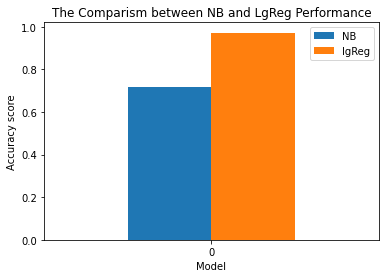

In [73]:
print("Exercise 12: create a model: Logistic regression, compare its performance with NB model \n")
models_dict = {"NB": GaussianNB(), "lgReg": LogisticRegression()}

models_accuracy_scores, _ = model_performance(models_dict)
print("The accuracy score of the two models are: ", models_accuracy_scores )

#Vizualise the comparison 
df_model_acc = pd.DataFrame(models_accuracy_scores, index=[0])
df_model_acc.index.name = "index"
df_model_acc.plot.bar(rot=0)
plt.xlabel("Model")
plt.ylabel("Accuracy score")
plt.title("The Comparism between NB and LgReg Performance");

The Logistic Regressor performs better than the Naive Bayes classifier.

Exercise 13: Retrain the two models but with shuffled data and see if affected their performance 

The accuracy score of the two models when data is shuffled are:  {'NB': 0.711, 'lgReg': 0.977}


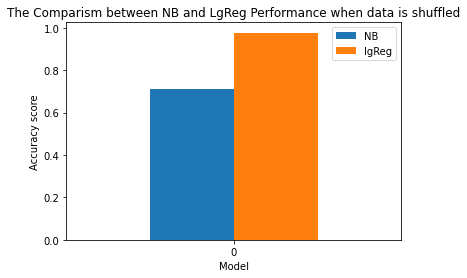

In [75]:
print("Exercise 13: Retrain the two models but with shuffled data and see if it affected their performance \n")

#Get shuffled split data
X_train, X_test, y_train, y_test = vet_split_func(cleaned_message, labels, shuffle = True) 

data_shuffled_models_scores, _ = model_performance(models_dict)
print("The accuracy score of the two models when data is shuffled are: ", data_shuffled_models_scores )

#Vizualise the comparison 
df_model_acc = pd.DataFrame(data_shuffled_models_scores, index=[0])
df_model_acc.index.name = "index"
df_model_acc.plot.bar(rot=0)
plt.xlabel("Model")
plt.ylabel("Accuracy score")
plt.title("The Comparism between NB and LgReg Performance when data is shuffled");

The effect is not significant. Maybe the position of the sentences have little effect on the models in deciding whether the sentence is a spam or not.

Exercise 14: For both models perform kfold cross validation, set shuffle true and false, compare the average performance of each model when shuffle is true and false. 

The kfold accuracy scores without shuffled data:  {'NB': [0.724, 0.724, 0.691, 0.708, 0.714], 'lgReg': [0.972, 0.974, 0.978, 0.969, 0.976]}

The kfold accuracy scores with shuffled data:  {'NB': [0.695, 0.706, 0.722, 0.703, 0.739], 'lgReg': [0.977, 0.978, 0.98, 0.966, 0.972]}


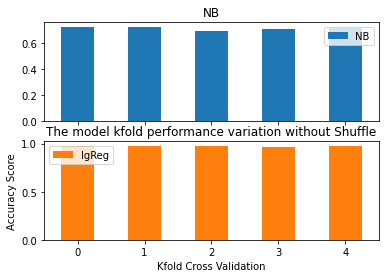

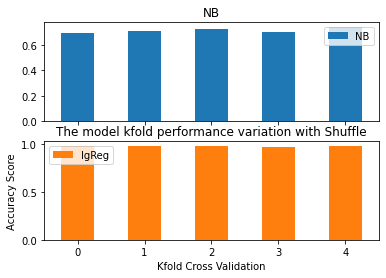

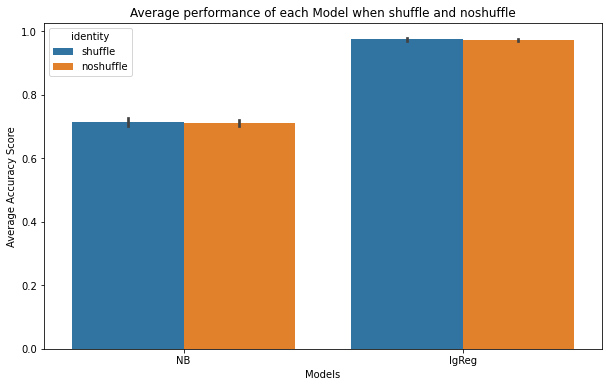

In [87]:
print("Exercise 14: For both models perform kfold cross validation, set shuffle true and false, compare the average performance of each model when shuffle is true and false. \n")

#Kfold performance without shuffle
kfold_scores_noshuffle = kfold_model_performance(models_dict, cleaned_message, labels)
print("The kfold accuracy scores without shuffled data: ", kfold_scores_noshuffle)
print()

#Kfold performance with shuffle
kfold_scores_shuffle = kfold_model_performance(models_dict, cleaned_message, labels, shuffle= True)
print("The kfold accuracy scores with shuffled data: ", kfold_scores_shuffle)

#Visualization
#preprocess the data
df_kfold_noshuffle = pd.DataFrame(kfold_scores_noshuffle)

#Visualize the performance variation in each stage during cross validation
df_kfold_noshuffle.plot.bar(rot=0, subplots = True)
plt.xlabel("Kfold Cross Validation")
plt.ylabel("Accuracy Score")
plt.title("The model kfold performance variation without Shuffle")

#Shuffle variation
df_kfold_shuffle = pd.DataFrame(kfold_scores_shuffle)
df_kfold_shuffle.plot.bar(rot=0, subplots = True)
plt.xlabel("Kfold Cross Validation")
plt.ylabel("Accuracy Score")
plt.title("The model kfold performance variation with Shuffle")

#Add identity
df_kfold_noshuffle["identity"] = "noshuffle"
df_kfold_shuffle["identity"] = "shuffle"

#concat the two df
df_kfold = pd.concat([df_kfold_shuffle, df_kfold_noshuffle])

#Reshape the dataframe
df_kfold_reshape = pd.melt(df_kfold, id_vars = "identity", var_name = "Model", value_name ="Accuracy" )
#print(df_kfold)
#df_kfold_reshape

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", hue = "identity", data = df_kfold_reshape)
plt.xlabel("Models")
plt.ylabel("Average Accuracy Score")
plt.title("Average performance of each Model when shuffle and noshuffle");


From graphies above, there are slight variation across both models during validation at each stage. Also, the shuffle has little impact on the average performance of each model during kfold cross validation.

In [93]:
print("Exercise 14 (5) Alter the values of k and observe the effect on both models performance.\n")
k_range = list(range(2,16,3))
collated_result = []
for k in k_range:
  kfold_result_k = kfold_model_performance(models_dict, cleaned_message, labels, k=k, shuffle=True)
  collated_result.append(kfold_result_k)
print(collated_result)

Exercise 14 (5) Alter the values of k and observe the effect on both models performance.

[{'NB': [0.74, 0.746], 'lgReg': [0.973, 0.964]}, {'NB': [0.695, 0.706, 0.722, 0.703, 0.739], 'lgReg': [0.977, 0.978, 0.98, 0.966, 0.972]}, {'NB': [0.688, 0.687, 0.7, 0.73, 0.704, 0.691, 0.714, 0.734], 'lgReg': [0.977, 0.977, 0.986, 0.978, 0.98, 0.963, 0.98, 0.967]}, {'NB': [0.692, 0.686, 0.692, 0.692, 0.729, 0.719, 0.696, 0.666, 0.688, 0.743, 0.733], 'lgReg': [0.986, 0.97, 0.974, 0.988, 0.976, 0.986, 0.974, 0.964, 0.974, 0.982, 0.968]}, {'NB': [0.678, 0.698, 0.683, 0.693, 0.683, 0.729, 0.719, 0.721, 0.69, 0.678, 0.678, 0.72, 0.753, 0.733], 'lgReg': [0.985, 0.97, 0.98, 0.98, 0.99, 0.982, 0.98, 0.982, 0.967, 0.967, 0.972, 0.985, 0.98, 0.962]}]


[{'NB': 0.743, 'lgReg': 0.968}, {'NB': 0.713, 'lgReg': 0.975}, {'NB': 0.706, 'lgReg': 0.976}, {'NB': 0.703, 'lgReg': 0.977}, {'NB': 0.704, 'lgReg': 0.977}]


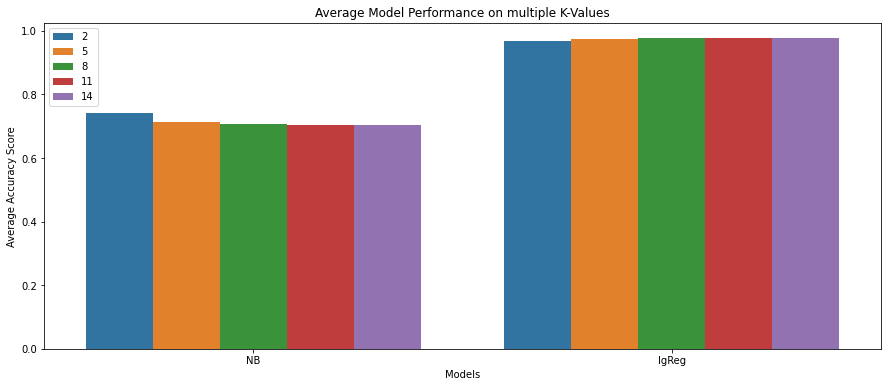

In [98]:
#Visualize the result
#Average the result per k
average_result_kvalues = average_kfold_result(collated_result)
print(average_result_kvalues)

df_result = pd.DataFrame(average_result_kvalues)

#Name the Index K
df_result.index.name = "K"

#Reset_index
df_result = df_result.reset_index()

#Replace K with
replace_k = {0:2, 1:5, 2:8, 3: 11, 4: 14}
df_result["K"] = df_result["K"].replace(replace_k)

#Reshape the df
df = pd.melt(df_result, id_vars="K", var_name="Model", value_name="Average_Accuracy")

#graph
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x="Model", y="Average_Accuracy", hue = "K", data = df)
plt.xlabel("Models")
plt.ylabel("Average Accuracy Score")
plt.title("Average Model Performance on multiple K-Values")
plt.legend(loc="upper left");

In [100]:
print("Exercise 15: Turn on the max_features in CountVectorizer and alter the value downward to observe the effect on both models ")

#The max_feature number is 5253

max_features = list(range(5253, 1, -1000))
print(max_features)
max_features_result_sheet = {}
for max_feature in max_features:
  #Split the vectoriized data with max_feature set to True
  X_train, X_test, y_train, y_test = vet_split_func(cleaned_message, labels, max_feature=max_feature, use_max_features=True)

  #Instantiate the model
  scores, _ = model_performance(models_dict)

  max_features_result_sheet[max_feature] = scores
max_features_result_sheet

Exercise 15: Turn on the max_features in CountVectorizer and alter the value downward to observe the effect on both models 
[5253, 4253, 3253, 2253, 1253, 253]


{5253: {'NB': 0.718, 'lgReg': 0.972},
 4253: {'NB': 0.718, 'lgReg': 0.973},
 3253: {'NB': 0.718, 'lgReg': 0.973},
 2253: {'NB': 0.714, 'lgReg': 0.974},
 1253: {'NB': 0.676, 'lgReg': 0.974},
 253: {'NB': 0.518, 'lgReg': 0.971}}

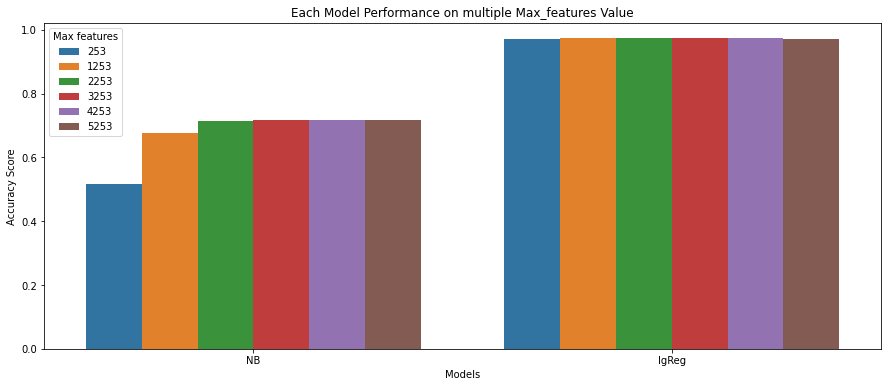

In [101]:
#Visualize the result
df_max_result = pd.DataFrame.from_dict(max_features_result_sheet, orient = "index")
df_max_result.index.name = "Max_features"
df_max_result = df_max_result.reset_index()

#Reshape the df
df_max = pd.melt(df_max_result, id_vars="Max_features", var_name = "Model", value_name = "Accuracy")

#plot graph
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x="Model", y="Accuracy", hue = "Max_features", data = df_max)
plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.title("Each Model Performance on multiple Max_features Value")
plt.legend(loc="upper left", title = "Max features");

When the max_features size dropped to 1253 and 253, there was a significant reduction in the performance of Naive Bayes classifier. However, there is insignificant effect on the performance of the logistic regressor.

In [3]:
print("Exercise 16: Use Brown corpus to train the vectorizer, and rep the BOW. Whats the impact on both model performance.\n")

#download the brown corpus words
nltk.download('brown')

Exercise 16: Use Brown corpus to train the vectorizer, and rep the BOW. Whats the impact on both model performance.



[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [108]:
#Extract the brown words
brown_words = brown.words()

#The brown_words are list of cleaned words and they are 1161192 in numbers

#Instantiate the countvectorizer
cnt_vet = CountVectorizer()

#Train it with brown words
cnt_vet.fit(brown_words)

#Vectorizer my cleaned_message
X_vet = cnt_vet.transform(cleaned_message).toarray()
y_vet = np.array(labels.to_list())

#Split the data
X_vet_train, X_vet_test, y_vet_train, y_vet_test = train_test_split(X_vet, y_vet, test_size = 0.3, shuffle=False)

vet_result_sheet = {}
for model_name, model_instance in models_dict.items():
  vet_model = model_instance

  vet_model.fit(X_vet_train, y_vet_train)

  vet_y_pred = vet_model.predict(X_vet_test)

  vet_score = (y_vet_test == vet_y_pred).sum()/len(y_vet_test)
  vet_result_sheet[model_name] = round(vet_score, 3)

print(vet_result_sheet)

{'NB': 0.261, 'lgReg': 0.937}


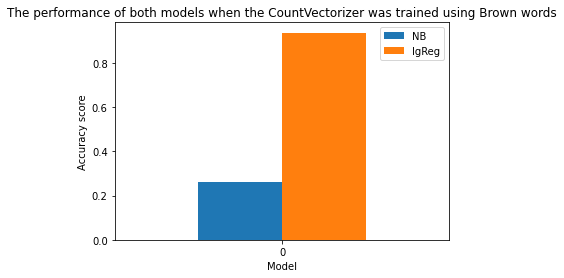

In [109]:
#Vislualise the result
df_model_acc = pd.DataFrame(vet_result_sheet, index=[0])
df_model_acc.index.name = "index"
df_model_acc.plot.bar(rot=0)
plt.xlabel("Model")
plt.ylabel("Accuracy score")
plt.title("The performance of both models when the CountVectorizer was trained using Brown words");

It affected both model performance, however, the performance of the Naive Bayes dropped significantly than Logistic Regression.